In [1]:
import datetime
import pathlib

from utils import check_autocorr_ts
from volume_feature import add_created_count_feat

import pandas as pd

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL
#obtain hierarchical reconciliation methods and evaluation
from matplotlib import pyplot as plt

from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM, Normality
from hierarchicalforecast.utils import aggregate

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
root_dir = pathlib.Path("../data")
dir_311 = root_dir/"311"/"2018"

df = pd.read_parquet(root_dir/"nypd"/"precincts")
df = df[df['created_H']>=datetime.date(2018,1,1)]
df

,borough,complaint_type,created_H,closed_H,created_date,closed_date,descriptor,status,resolution_description,resolution_action_updated_date,...,created_bo_ag,created_bo_co,open,open_bo,open_ag,open_co,open_bo_ag,open_bo_co,precinct,sector
24858,BROOKLYN,Traffic,2018-01-16 07:00:00,2018-01-16 11:00:00,2018-01-16 07:53:08,2018-01-16 11:07:21,Congestion/Gridlock,Closed,The Police Department responded to the complai...,2018-01-16 11:07:21,...,25,1,107899,30864,383,1,51,1,,
43904,BRONX,Derelict Vehicle,2018-01-27 13:00:00,2018-01-27 16:00:00,2018-01-27 13:20:24,2018-01-27 16:25:23,With License Plate,Closed,This complaint does not fall under the Police ...,2018-01-27 16:25:23,...,12,2,98111,21763,432,98,94,4,,
50792,BRONX,Derelict Vehicle,2018-01-31 07:00:00,2018-01-31 11:00:00,2018-01-31 07:53:07,2018-01-31 11:47:19,With License Plate,Closed,The Police Department responded to the complai...,2018-01-31 11:47:19,...,10,2,96487,21470,245,68,87,8,,
66268,BRONX,Derelict Vehicle,2018-02-09 20:00:00,2018-02-10 04:00:00,2018-02-09 20:37:21,2018-02-10 04:58:29,With License Plate,Closed,The Police Department responded to the complai...,2018-02-10 04:58:29,...,23,1,91431,19658,364,99,90,7,,
100312,BRONX,Derelict Vehicle,2018-03-01 12:00:00,2018-03-01 16:00:00,2018-03-01 12:38:59,2018-03-01 16:08:53,With License Plate,Closed,Your request can not be processed at this time...,2018-03-01 16:08:54,...,8,4,81968,16040,405,131,105,9,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750120,BROOKLYN,Noise - Street/Sidewalk,2018-12-30 22:00:00,2018-12-30 23:00:00,2018-12-30 22:32:22,2018-12-30 23:27:25,Loud Talking,Closed,The Police Department responded to the complai...,2018-12-30 23:27:25,...,53,3,96441,31402,819,68,103,4,94,094C
750676,BROOKLYN,Noise - Commercial,2018-12-31 04:00:00,2018-12-31 06:00:00,2018-12-31 04:20:29,2018-12-31 06:12:56,Banging/Pounding,Closed,The Police Department responded to the complai...,2018-12-31 06:12:56,...,7,1,95890,31119,670,19,67,4,94,094C
751615,BROOKLYN,Noise - Commercial,2018-12-31 18:00:00,2018-12-31 20:00:00,2018-12-31 18:50:20,2018-12-31 20:10:25,Loud Music/Party,Closed,The Police Department responded to the complai...,2018-12-31 20:10:25,...,28,1,94579,30276,736,17,69,4,94,094C
751868,BROOKLYN,Blocked Driveway,2018-12-31 21:00:00,2018-12-31 23:00:00,2018-12-31 21:24:26,2018-12-31 23:18:44,No Access,Closed,The Police Department responded and upon arriv...,2018-12-31 23:18:44,...,48,11,94636,30397,777,148,93,27,94,094C


In [3]:
weather = pd.read_parquet(root_dir/"weather"/"unprocessed"/"year=2018")
weather['date_H'] = weather['DATE'].dt.round('H')
hourly_weather = weather.groupby('date_H').head(1).drop('DATE', axis='columns')
hourly_weather

,temperature_c,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,date_H
0,-10.6,<NA>,<NA>,320,8.2,-18.3,2018-01-01 00:00:00
1,-10.6,1,0.0,320,6.7,-18.3,2018-01-01 01:00:00
2,-11.1,1,0.0,320,7.2,-18.3,2018-01-01 02:00:00
3,-11.7,1,0.0,310,8.2,-18.3,2018-01-01 03:00:00
5,-11.7,1,0.0,320,7.7,-17.8,2018-01-01 04:00:00
...,...,...,...,...,...,...,...
13946,6.7,1,0.0,140,4.1,2.2,2018-12-31 20:00:00
13948,6.7,1,0.5,150,3.1,3.3,2018-12-31 21:00:00
13950,6.7,1,1.0,130,3.6,3.3,2018-12-31 22:00:00
13951,6.7,1,1.3,120,4.6,4.4,2018-12-31 23:00:00


In [4]:
crime = pd.read_parquet(root_dir/"crime"/"processed")
crime = crime[crime['crime_H']>=datetime.date(2018,1,1)]
crime.rename({'crime_H':'created_H'}, axis='columns', inplace=True)
crime = crime.convert_dtypes(dtype_backend='pyarrow')
# get all the counts
hourly_crime = crime[['created_H','precinct', 'crime_degree','idx']].groupby(['created_H','precinct', 'crime_degree'], observed=False).count().unstack([ 'crime_degree'])
hourly_crime.columns = hourly_crime.columns.droplevel().rename('')
hourly_crime.reset_index(inplace=True)

In [5]:
df['precinct'] = pd.Categorical(df['precinct'].replace('', pd.NA).astype('int64[pyarrow]'))
df = pd.merge(df, hourly_weather, how='left', left_on=['created_H'], right_on=['date_H'])
df = pd.merge(df, hourly_crime, how='left', left_on=['created_H', 'precinct'], right_on=['created_H', 'precinct'],)
del hourly_crime, hourly_weather, crime, weather


In [21]:
add_created_count_feat(df, ['borough','precinct','complaint_type'], inplace=True)

c:\Users\Morri\Documents\Notebooks\Capstone\src\volume_feature.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  created_by_date = df.groupby(


,created_H,borough,precinct,complaint_type,closed_H,created_date,closed_date,descriptor,status,resolution_description,...,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,date_H,FELONY,MISDEMEANOR,VIOLATION,created_bo_pr_co
64,2018-01-01 05:00:00,MANHATTAN,1,Noise - Commercial,2018-01-01 06:00:00,2018-01-01 05:39:19,2018-01-01 06:24:11,Loud Music/Party,Closed,The Police Department responded to the complai...,...,1,0.0,330,6.2,-18.3,2018-01-01 05:00:00,0,0,2,1
65,2018-01-03 12:00:00,MANHATTAN,1,Illegal Parking,2018-01-03 14:00:00,2018-01-03 12:57:42,2018-01-03 14:00:13,Blocked Sidewalk,Closed,The Police Department issued a summons in resp...,...,1,0.0,270,3.1,-17.8,2018-01-03 12:00:00,0,0,0,1
66,2018-01-04 03:00:00,MANHATTAN,1,Noise - Vehicle,2018-01-04 04:00:00,2018-01-04 03:30:38,2018-01-04 04:44:41,Engine Idling,Closed,The Police Department responded to the complai...,...,1,0.0,50,3.1,-11.1,2018-01-04 03:00:00,0,0,0,1
67,2018-01-04 17:00:00,MANHATTAN,1,Homeless Encampment,2018-01-04 19:00:00,2018-01-04 17:39:31,2018-01-04 19:55:16,N/A,Closed,The Police Department responded and upon arriv...,...,1,0.5,340,13.4,-6.1,2018-01-04 17:00:00,0,1,0,1
68,2018-01-05 06:00:00,MANHATTAN,1,Noise - Residential,2018-01-05 07:00:00,2018-01-05 06:43:08,2018-01-05 07:35:03,Loud Music/Party,Closed,The Police Department responded to the complai...,...,1,0.0,290,10.8,-15.0,2018-01-05 06:00:00,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749174,2018-12-30 22:00:00,BROOKLYN,94,Noise - Street/Sidewalk,2018-12-30 23:00:00,2018-12-30 22:32:22,2018-12-30 23:27:25,Loud Talking,Closed,The Police Department responded to the complai...,...,1,0.0,160,3.1,-2.2,2018-12-30 22:00:00,0,0,0,1
749175,2018-12-31 04:00:00,BROOKLYN,94,Noise - Commercial,2018-12-31 06:00:00,2018-12-31 04:20:29,2018-12-31 06:12:56,Banging/Pounding,Closed,The Police Department responded to the complai...,...,1,0.0,170,3.1,-0.6,2018-12-31 04:00:00,0,0,0,1
749176,2018-12-31 18:00:00,BROOKLYN,94,Noise - Commercial,2018-12-31 20:00:00,2018-12-31 18:50:20,2018-12-31 20:10:25,Loud Music/Party,Closed,The Police Department responded to the complai...,...,1,0.0,170,5.1,1.1,2018-12-31 18:00:00,0,0,0,1
749177,2018-12-31 21:00:00,BROOKLYN,94,Blocked Driveway,2018-12-31 23:00:00,2018-12-31 21:24:26,2018-12-31 23:18:44,No Access,Closed,The Police Department responded and upon arriv...,...,1,0.5,150,3.1,3.3,2018-12-31 21:00:00,0,0,0,1


In [22]:
df.dropna(axis=0, subset=['borough', 'precinct'], inplace=True)


In [23]:
df.drop([
    'created_date','closed_H',
       'closed_date', 'descriptor', 'status', 'resolution_description',
       'resolution_action_updated_date', 'incident_zip', 'city', 'bbl',
       'latitude', 'longitude', 'due_date','hours_to_complete','created',
       'created_bo', 'created_ag', 'created_co', 'created_bo_ag',
       'created_bo_co', 'open', 'open_bo', 'open_ag', 'open_co', 'open_bo_ag',
       'open_bo_co','sector','date_H'], axis='columns', inplace=True)

In [31]:
df.drop(['precip_period_hrs','precip_accumulation_mm'], axis='columns', inplace=True)

In [32]:
df.dropna(inplace=True)

In [41]:
df['precinct'] = pd.to_numeric(df['precinct']).astype('string[pyarrow]')

In [59]:
heirarchies = [
    ['borough'],
    [ 'borough','precinct'],
    [ 'borough','precinct','complaint_type']
    # [ 'borough','precinct', 'sector'],
    # [ 'borough','precinct', 'sector', 'complaint_type']
]

hdf = df[df['borough']!= 'Unspecified']
hdf.rename({'created_H':'ds','created_bo_pr_co':'y'}, axis=1, inplace=True)
Y_df, H_df, tags = aggregate(
    hdf,
    spec=heirarchies
)


C:\Users\Morri\AppData\Local\Temp\ipykernel_17500\2280393703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hdf.rename({'created_H':'ds','created_bo_pr_co':'y'}, axis=1, inplace=True)


,ds,y
unique_id,,
BRONX,2018-01-01 00:00:00,28
BRONX,2018-01-01 01:00:00,200
BRONX,2018-01-01 02:00:00,205
BRONX,2018-01-01 03:00:00,292
BRONX,2018-01-01 04:00:00,114
...,...,...
STATEN ISLAND/123/Traffic,2018-11-20 17:00:00,1
STATEN ISLAND/123/Traffic,2018-12-04 12:00:00,1
STATEN ISLAND/123/Traffic,2018-12-07 03:00:00,1


In [68]:
Y_df = Y_df.reset_index('unique_id').set_index(['unique_id','ds',]).unstack('unique_id').fillna(0).stack().reset_index('ds')


,ds,y
unique_id,,
BRONX,2018-01-01 00:00:00,28
BRONX/114,2018-01-01 00:00:00,0
BRONX/114/Illegal Parking,2018-01-01 00:00:00,0
BRONX/40,2018-01-01 00:00:00,4
BRONX/40/Animal Abuse,2018-01-01 00:00:00,0
...,...,...
STATEN ISLAND/123/Non-Emergency Police Matter,2018-12-31 23:00:00,0
STATEN ISLAND/123/Panhandling,2018-12-31 23:00:00,0
STATEN ISLAND/123/Posting Advertisement,2018-12-31 23:00:00,0


In [ ]:
#split train/test sets
Y_test_df  = Y_df.groupby('unique_id').tail(120)
Y_train_df = Y_df.drop(Y_test_df.index)


hrec = HierarchicalReconciliation(
    reconcilers =
        [
            MinTrace('ols', nonnegative=True,num_threads=-1),
            ERM('closed'),
            # BottomUp()
        ]
)
# Y_df = bdf[(bdf['ds']>datetime.date(year=2018, month=10, day=1)) & (bdf['ds']<datetime.date(year=2018, month=12, day=1))]

# models = [MSTL(
#     season_length=[24, 24 * 7], # seasonalities of the time series
#     trend_forecaster=AutoARIMA(trace=True) # model used to forecast trend
# )]
model = AutoARIMA(trace=True,d=0,D=0)

In [ ]:
def aggregate(
    df: pd.DataFrame,
    spec: list,
    sparse_s: bool = False,
):
    """Utils Aggregation Function.
    Aggregates bottom level series contained in the pandas DataFrame `df` according
    to levels defined in the `spec` list.

    Parameters
    ----------
    df : pandas DataFrame
        Dataframe with columns `['ds', 'y']` and columns to aggregate.
    spec : list of list of str
        List of levels. Each element of the list should contain a list of columns of `df` to aggregate.
    is_balanced : bool (default=False)
        Deprecated.
    sparse_s : bool (default=False)
        Return `S_df` as a sparse dataframe.

    Returns
    -------
    Y_df : pandas DataFrame
        Hierarchically structured series.
    S_df : pandas DataFrame
        Summing dataframe.
    tags : dict
        Aggregation indices.
    """
    # Checks
    if df.isnull().values.any():
        raise ValueError('`df` contains null values')


    # compute aggregations and tags
    spec = sorted(spec, key=len)
    bottom = spec[-1]
    aggs = []
    tags = {}
    for levels in spec:
        agg = df.groupby(levels + ['ds'], observed=True)['y'].sum()
        if not agg.index.is_monotonic_increasing:
            agg = agg.sort_index()
        agg = agg.reset_index('ds')
        group = agg.index.get_level_values(0)
        if not pd.api.types.is_string_dtype(group.dtype):
            group = group.astype(str)
        for level in levels[1:]:
            group = group + '/' + agg.index.get_level_values(level).str.replace('/', '_')
        agg.index = group
        agg.index.name = 'unique_id'
        tags['/'.join(levels)] = group.unique().values
        aggs.append(agg)
    Y_df = pd.concat(aggs)

    # construct S
    bottom_key = '/'.join(bottom)
    bottom_levels = tags[bottom_key]
    S = np.empty((len(bottom_levels), len(spec)), dtype=object)
    for j, levels in enumerate(spec[:-1]):
        S[:, j] = _to_upper_hierarchy(bottom, bottom_levels, '/'.join(levels))
    S[:, -1] = tags[bottom_key]
    categories = list(tags.values())
    try:
        encoder = OneHotEncoder(categories=categories, sparse_output=sparse_s, dtype=np.float32)
    except TypeError:  # sklearn < 1.2
        encoder = OneHotEncoder(categories=categories, sparse=sparse_s, dtype=np.float32)
    S = encoder.fit_transform(S).T
    if sparse_s:
        df_constructor = pd.DataFrame.sparse.from_spmatrix
    else:
        df_constructor = pd.DataFrame
    S_df = df_constructor(S, index=np.hstack(categories), columns=bottom_levels)
    return Y_df, S_df, tags

In [52]:
# sf = StatsForecast(
#     models = models,
#     freq = 'H',
#     n_jobs=-1,
#     verbose=True
#     )
model.fit(Y_df)
sf.fit(df=Y_train_df)

c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:551: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


StatsForecast(models=[AutoARIMA])

<Axes: xlabel='ds'>

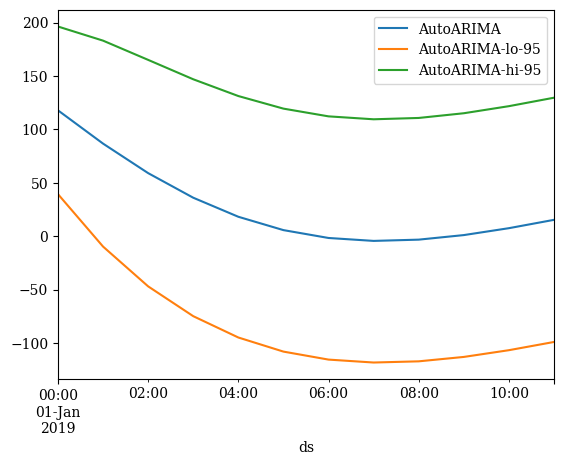

In [ ]:
from utilsforecast.plotting import plot_series
fig = plot_series(series, plot_random=False, max_insample_length=50, engine='matplotlib')
fcts

In [ ]:
import numpy as np
from utilsforecast.losses import mae
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

hrec = HierarchicalReconciliation(reconcilers=hrec)
Y_rec_df = hrec.reconcile(Y_hat_df=fcts, Y_df=Y_train_df,
                          S=H_df, tags=tags)

evaluator = HierarchicalEvaluation(evaluators=[mse, mae])
evaluator.evaluate(Y_hat_df=fcts, Y_test=Y_test_df.set_index('unique_id'),
                   tags=tags, benchmark='Naive')


In [47]:
fcts

,ds,MSTL,MSTL-lo-95,MSTL-hi-95
unique_id,,,,
BRONX,2019-01-01 00:00:00,130.530060,76.479942,184.580170
BRONX/114,2018-06-21 08:00:00,1.000000,0.999520,1.000480
BRONX/114/Illegal Parking,2018-06-21 08:00:00,1.000000,0.999520,1.000480
BRONX/40,2019-01-01 00:00:00,0.285686,-7.873256,8.444629
BRONX/40/Animal Abuse,2018-12-30 13:00:00,3.875318,3.875153,3.875483
...,...,...,...,...
STATEN ISLAND/123/Non-Emergency Police Matter,2018-12-26 16:00:00,3.562401,3.562401,3.562401
STATEN ISLAND/123/Panhandling,2018-07-31 19:00:00,1.000000,1.000000,1.000000
STATEN ISLAND/123/Posting Advertisement,2018-05-07 18:00:00,1.000000,1.000000,1.000000


In [ ]:
# to_comp_df = df[['created_H', 'hours_to_complete']].groupby('created_H').mean().fillna(0)
# target_bo_df = df[['created_H','borough', 'hours_to_complete']] \
#         .groupby(['created_H','borough']) \
#                 .mean().unstack(['borough']).fillna(0)
# target_pre_df = df[['created_H','sector', 'hours_to_complete']] \
#         .groupby(['created_H','sector']) \
#                 .mean().unstack(['sector']).fillna(0)
# target_sect_df = df[['created_H','precinct', 'hours_to_complete']] \
#         .groupby(['created_H','precinct']) \
#                 .mean().unstack(['precinct']).fillna(0)
# check_autocorr_ts(to_comp_df)

# check_autocorr_ts(target_bo_df,plots=False)

# check_autocorr_ts(target_pre_df, plots=False)
# check_autocorr_ts(target_sect_df, plots=False)

In [9]:
heirarchies = [
    ['borough'],
    [ 'borough','precinct'],
    [ 'borough','precinct','complaint_type']
    # [ 'borough','precinct', 'sector'],
    # [ 'borough','precinct', 'sector', 'complaint_type']
]

hdf = df[df['borough']!= 'Unspecified']
hdf = hdf[['created_H','hours_to_complete','borough','precinct', 'sector']]
hdf.rename({'created_H':'ds','hours_to_complete':'y'}, axis=1, inplace=True)
# hdf.rename({'hours_to_complete':'y'}, axis=1,inplace=True)


c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:551: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\Morri\.conda\envs\capstone\lib\site-packages\statsforecast\core.py:551:

TypeError: float() argument must be a string or a real number, not 'NAType'

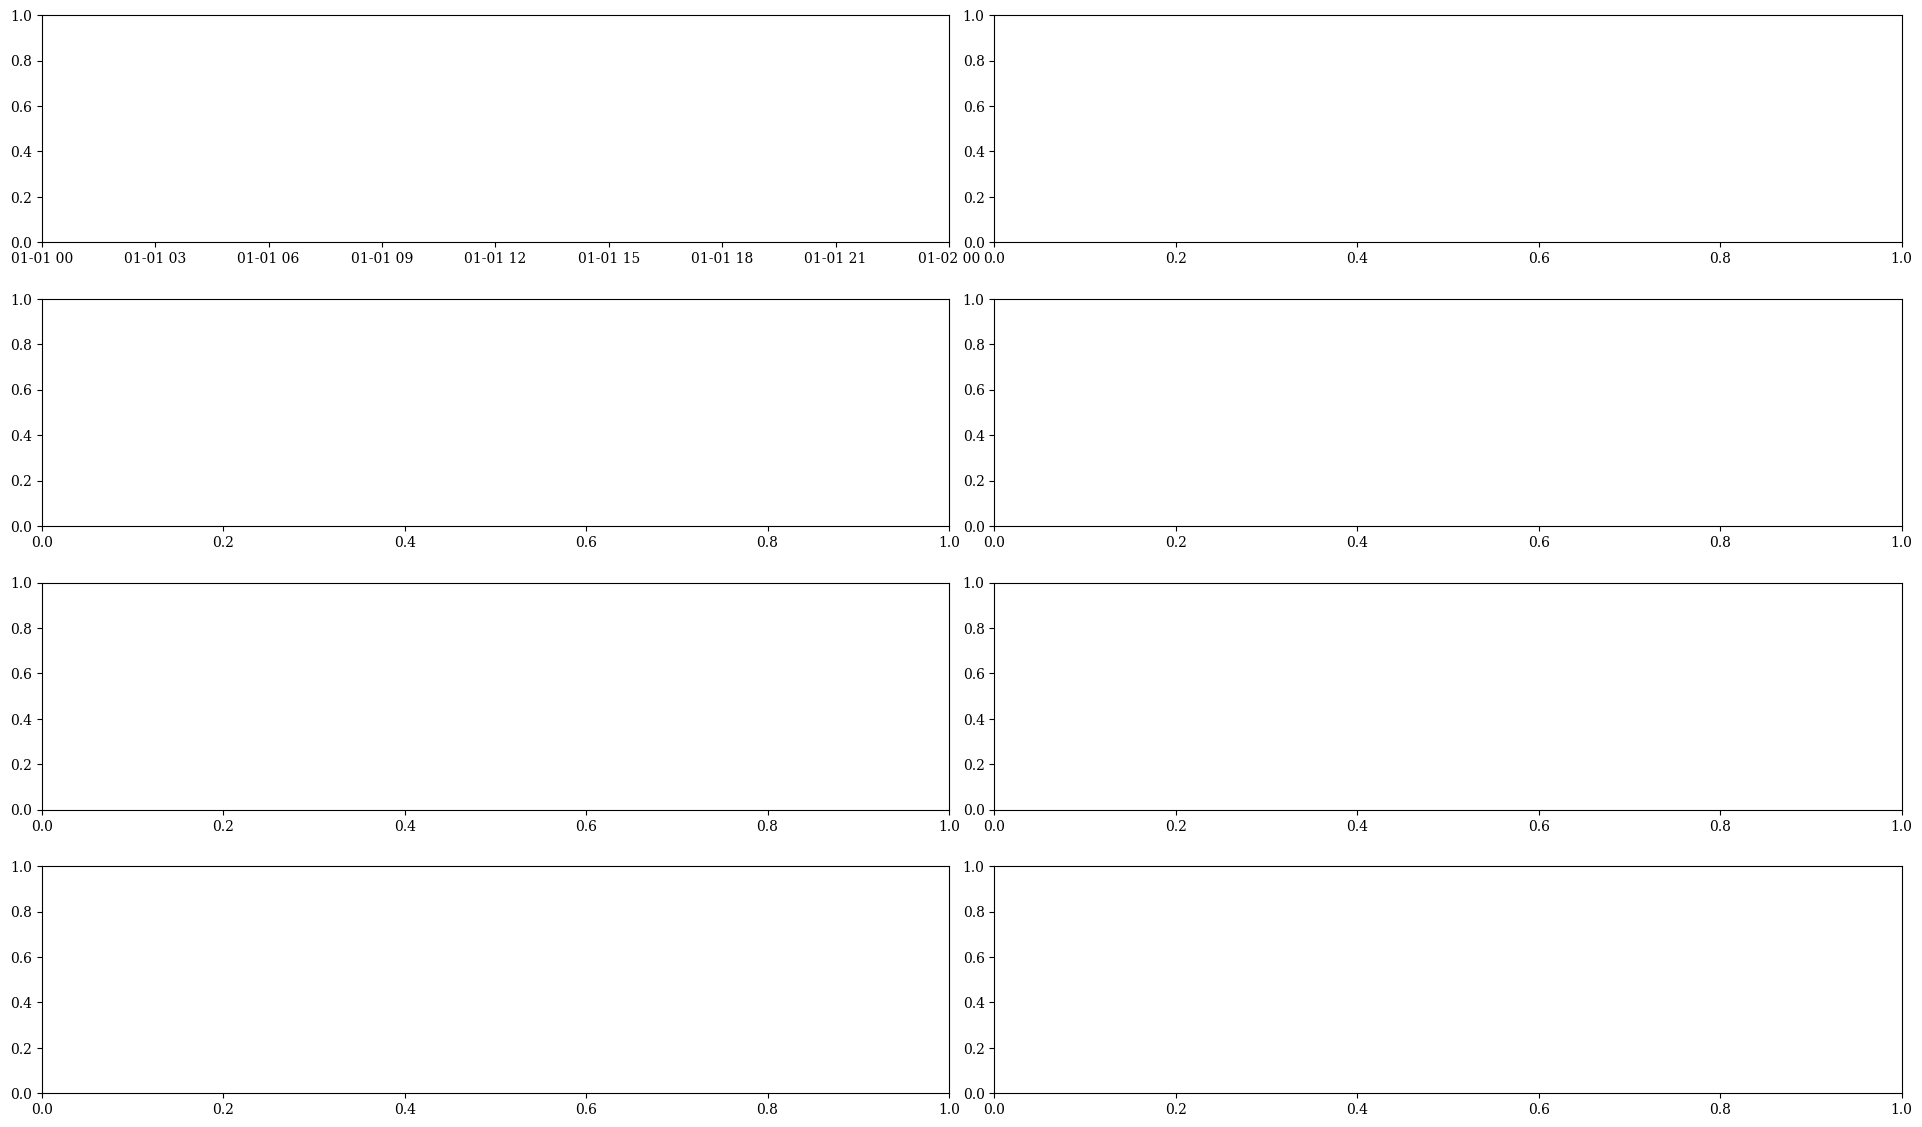

In [10]:
bdf, H_df, tags = aggregate(
    hdf,
    spec=heirarchies
)
hrec = HierarchicalReconciliation(
    reconcilers =
        [
            MinTrace('ols', nonnegative=True,num_threads=-1),
            ERM('closed'),
            # BottomUp()
        ]
)
Y_df = bdf[(bdf['ds']>datetime.date(year=2018, month=10, day=1)) & (bdf['ds']<datetime.date(year=2018, month=12, day=1))]

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA(trace=True) # model used to forecast trend
)]
models = [
    AutoARIMA(trace=True,d=0,D=0)
]
sf = StatsForecast(
    models = models,
    freq = 'H',
    df=Y_df,
    n_jobs=-1,
    verbose=True
    )
sf.fit()
fcts  = sf.forecast(h=1,df=bdf, level=[95])
StatsForecast.plot(df=Y_df, forecasts_df=fcts[fcts.index.isin(bdf.index)].fillna(0))

In [18]:
sf.save(f'../models/{datetime.datetime.now()} - MSTL.model')

Saving StatsForecast object of size 37.36MB.
StatsForecast object saved
